In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met, u_darrays as uda
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io
import matplotlib.patches as patches
import pickle
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors.p', "rb"))
ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb"))

shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
tcwvfac_all =  np.array(ftcw['rel']) 

precip_all = ftcw['prcp_hist']

tcabsfac = np.mean(ftcw['abs']) #1.21 # absolute change

tcabserr = np.std(ftcw['abs']) #0.06 #mm h
tcrelerr = np.std(ftcw['rel']) #0.18 #%

In [4]:
print('Shear scaling', shearfac)
print('TCW scaling', tcwvfac_all)

Shear scaling 0.7003135334190702
TCW scaling [1.16296269 1.14583054 1.16296269 1.19185658 1.10917452 1.16007311
 1.09546043 1.1853091  1.13894869 1.32547751 1.20666992 1.30495387
 1.22251442 1.3176084  1.23383721 1.26747419 1.46585397 1.32938129
 1.4510043  1.45911276]


In [5]:
ftcw

{'rel': array([1.16296269, 1.14583054, 1.16296269, 1.19185658, 1.10917452,
        1.16007311, 1.09546043, 1.1853091 , 1.13894869, 1.32547751,
        1.20666992, 1.30495387, 1.22251442, 1.3176084 , 1.23383721,
        1.26747419, 1.46585397, 1.32938129, 1.4510043 , 1.45911276]),
 'abs': [1.4703788751984475,
  1.1938972394584302,
  1.168893468170798,
  1.1898706697993975,
  1.1554952615026859,
  1.1928813898435546,
  1.1107330531476685,
  1.170165853726141,
  1.1527210158119878,
  1.2754827256642673,
  1.1722203998563108,
  1.2479030289406612,
  1.1749292208303013,
  1.224513037936488,
  1.1844271554845258,
  1.2094912358781642,
  1.3202586825401474,
  1.212052767412634,
  1.3035634296150307,
  1.205227966220739],
 'futslope': 0.6859065709797977,
 'histslope': 0.49638498012944865,
 'futinter': 22.438128945665746,
 'histinter': 20.434819209386152,
 'tcw_hist': array([28.28, 35.06, 36.94, 38.26, 39.34, 40.3 , 41.14, 41.9 , 42.63,
        43.31, 43.95, 44.56, 45.19, 45.83, 46.5 , 47.23, 4

In [6]:
ouaga=[-2.52,0.52,11.38,13.38]
niamey = [12.51,14.51,1.13,3.13] #13.5116° N, 2.1254° E
timbuktu = [15.77,17.77, 2,4] #16.7666° N, 3.0026° W

def calc_mcs_stuff(dic, domain):
    m1=7
    m2=9
    dicout = dic[(dic.lon>=domain[0])&(dic.lon<=domain[1])&(dic.lat>=domain[2])&(dic.lat<=domain[3])& (dic.month>=m1) & (dic.month<=m2) & (dic.q925>=8.) & (dic.shear>0) &  (dic.prcp>=8) & (dic.theta_e>=-40) & (dic.area>=5000) & (dic.tmin<=-55)]
    return dicout

In [7]:
obs_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/obs_MCS_fig2.p', "rb"))
cp4hist_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4hist_MCS_fig2_5-20N.p', "rb"))
cp4fut_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4fut_MCS_fig2_5-20N.p', "rb"))

In [1073]:
np.min(cp4hist_mcs_d)

prcp        8.292375e-15
q925        8.008571e+00
t925        1.920000e+01
tcwv        1.765298e+01
tgrad       1.336349e-03
tbox       -9.340306e-02
shear       4.336735e-02
month       5.000000e+00
area        5.014240e+03
tmin       -8.076002e+01
tmean      -7.198553e+01
lat         9.008251e+00
lon        -1.176276e+01
theta_es   -5.366721e+00
theta_e    -2.064152e+01
dtype: float64

In [8]:
obs_mcs95 = calc_mcs_stuff(obs_mcs_d).max()
cp4hist_mcs95 = calc_mcs_stuff(cp4hist_mcs_d).max()
cp4fut_mcs95 = calc_mcs_stuff(cp4fut_mcs_d).max()

In [9]:
cp4fut_mcs95

prcp           110.968346
q925            23.693061
t925            40.090000
tcwv            83.587056
tgrad            0.053654
tbox            10.369864
shear           26.719388
month            9.000000
area        257546.080000
tmin           -56.149931
tmean          -52.260436
lat             13.362003
lon              0.508759
theta_es       133.063547
theta_e         19.321554
dtype: float64

In [10]:
77*1.22

93.94

In [11]:
obs_mcs05 = calc_mcs_stuff(obs_mcs_d).quantile(0.05)
cp4hist_mcs05 = calc_mcs_stuff(cp4hist_mcs_d).quantile(0.05)
cp4fut_mcs05 = calc_mcs_stuff(cp4fut_mcs_d).quantile(0.05)

In [12]:
obs_mcs50 = calc_mcs_stuff(obs_mcs_d).quantile(0.50)
cp4hist_mcs50 = calc_mcs_stuff(cp4hist_mcs_d).quantile(0.50)
cp4fut_mcs50 = calc_mcs_stuff(cp4fut_mcs_d).quantile(0.50)

In [13]:
obs_mcs_mean = calc_mcs_stuff(obs_mcs_d).mean()
cp4hist_mcs_mean = calc_mcs_stuff(cp4hist_mcs_d).mean()
cp4fut_mcs_mean = calc_mcs_stuff(cp4fut_mcs_d).mean()

In [14]:
cp4diff_mcs_mean = cp4fut_mcs_mean-cp4hist_mcs_mean

In [15]:
cp4diff_mcs95 = cp4fut_mcs95-cp4hist_mcs95

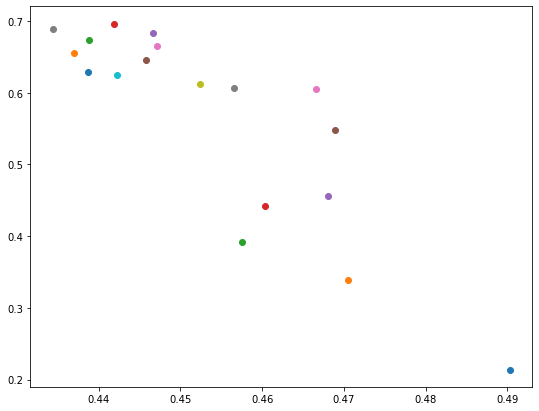

In [16]:
f = plt.figure(figsize=(9,7))
for p in np.arange(0.1,1,0.05):
    obs_mcs50 = calc_mcs_stuff(obs_mcs_d).quantile(p)
    cp4hist_mcs50 = calc_mcs_stuff(cp4hist_mcs_d).quantile(p)
    cp4fut_mcs50 = calc_mcs_stuff(cp4fut_mcs_d).quantile(p) 
    plt.scatter((cp4fut_mcs50['tcwv']-cp4hist_mcs50['tcwv'])/cp4hist_mcs50['tcwv'], (cp4fut_mcs50['prcp']-cp4hist_mcs50['prcp'])/cp4hist_mcs50['prcp'])

In [17]:
cp4fut_mcs05['prcp']-cp4hist_mcs05['prcp']

1.6892131805774184

In [18]:
(cp4fut_mcs05['tcwv']-cp4hist_mcs05['tcwv'])/cp4hist_mcs05['tcwv']

0.5297307329809752

In [19]:
cp4_tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc').sel(longitude=slice(-2.52,0.52), latitude=slice(11.38,13.38)).mean()
cp4_tcw_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_tcwv_daily.nc').sel(longitude=slice(-2.52,0.52), latitude=slice(11.38,13.38)).mean()
cp4_prcp_fut = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_p95Rain_gt5mm.nc').sel(longitude=slice(-2.52,0.52), latitude=slice(11.38,13.38)).mean()
cp4_prcp_hist = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_p95Rain_gt5mm.nc').sel(longitude=slice(-2.52,0.52), latitude=slice(11.38,13.38)).mean()

In [20]:
cp4_tcw_hist

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tcwv     float32 45.939575

In [21]:
cp4_u925_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u925_daily.nc').sel(longitude=slice(-2.52,0.52), latitude=slice(11.38,13.38)).mean()
cp4_u925_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u925_daily.nc').sel(longitude=slice(-2.52,0.52), latitude=slice(11.38,13.38)).mean()
cp4_u600_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u600_daily.nc').sel(longitude=slice(-2.52,0.52), latitude=slice(11.38,13.38)).mean()
cp4_u600_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u600_daily.nc').sel(longitude=slice(-2.52,0.52), latitude=slice(11.38,13.38)).mean()

In [22]:
cp4_shear_hist = cp4_u925_hist-cp4_u600_hist
cp4_shear_fut = cp4_u925_fut-cp4_u600_fut

In [23]:
cp4_tcw_rel = (cp4_tcw_fut-cp4_tcw_hist)/cp4_tcw_hist
cp4_tcw = (cp4_tcw_fut-cp4_tcw_hist)#/cp4_tcw_hist

In [24]:
cp4_shear_abs = cp4_shear_fut-cp4_shear_hist

In [25]:
cp4_tcw_rel

<xarray.Dataset>
Dimensions:                  ()
Coordinates:
    forecast_reference_time  object ...
Data variables:
    tcwv                     float32 0.462189

In [26]:
(cp4diff_mcs_mean['tcwv']/cp4hist_mcs_mean['tcwv'])

0.4554881177116727

In [27]:
cp4_prcp_fut.name = 'prcp'
cp4_prcp_hist.name = 'prcp'

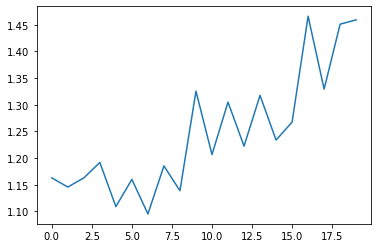

In [28]:
plt.plot(tcwvfac_all)

In [29]:
cp4_tcw_hist['tcwv'].values

array(45.939575, dtype=float32)

In [30]:
cp4hist_mcs95['tcwv']

86.96010917494094

In [31]:
isclose = np.nanargmin(np.abs(cp4hist_mcs95['tcwv']-ftcw['tcw_hist']))
cp4_pos_array95 = tcwvfac_all[isclose]
cp4_prcp_array95 = ftcw['prcp_hist'][isclose]

In [32]:
isclose = np.nanargmin(np.abs(cp4hist_mcs05['tcwv']-ftcw['tcw_hist']))
cp4_pos_array05 = tcwvfac_all[isclose]
cp4_prcp_array05 = ftcw['prcp_hist'][isclose]

In [33]:
print(cp4_pos_array95)
print(cp4_pos_array05)

1.4591127596499938
1.1629626914381843


In [34]:
cp4hist_mcs95['prcp']

67.88922808062415

In [35]:
(cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp'])

43.07911745662801

In [36]:
(cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp'])/(cp4fut_mcs95['tcwv']-cp4hist_mcs95['tcwv'])

-12.771551055147988

In [37]:
(cp4fut_mcs95['tcwv']-cp4hist_mcs95['tcwv'])/cp4hist_mcs95['tcwv']

-0.03878850822960512

In [38]:
(cp4fut_mcs95['tcwv']-cp4hist_mcs95['tcwv']) * 1.33 + obs_mcs95['prcp']  #observed deltaRain is 30mm too

86.93719957498996

In [39]:
cp4_prcp_array95

47.39591251215902

In [40]:
obs_mcs95['prcp']

91.42335994579477

In [41]:
obs_mcs95['tcwv']

54.3616943359375

In [42]:
cp4hist_mcs95['tcwv']

86.96010917494094

In [43]:
cp4_tcw_hist['tcwv'].values

array(45.939575, dtype=float32)

In [44]:
cmip_tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_*.nc', concat_dim='model_name', combine='by_coords').load()

In [45]:
model_names = cmip_tcw_map.model_name

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

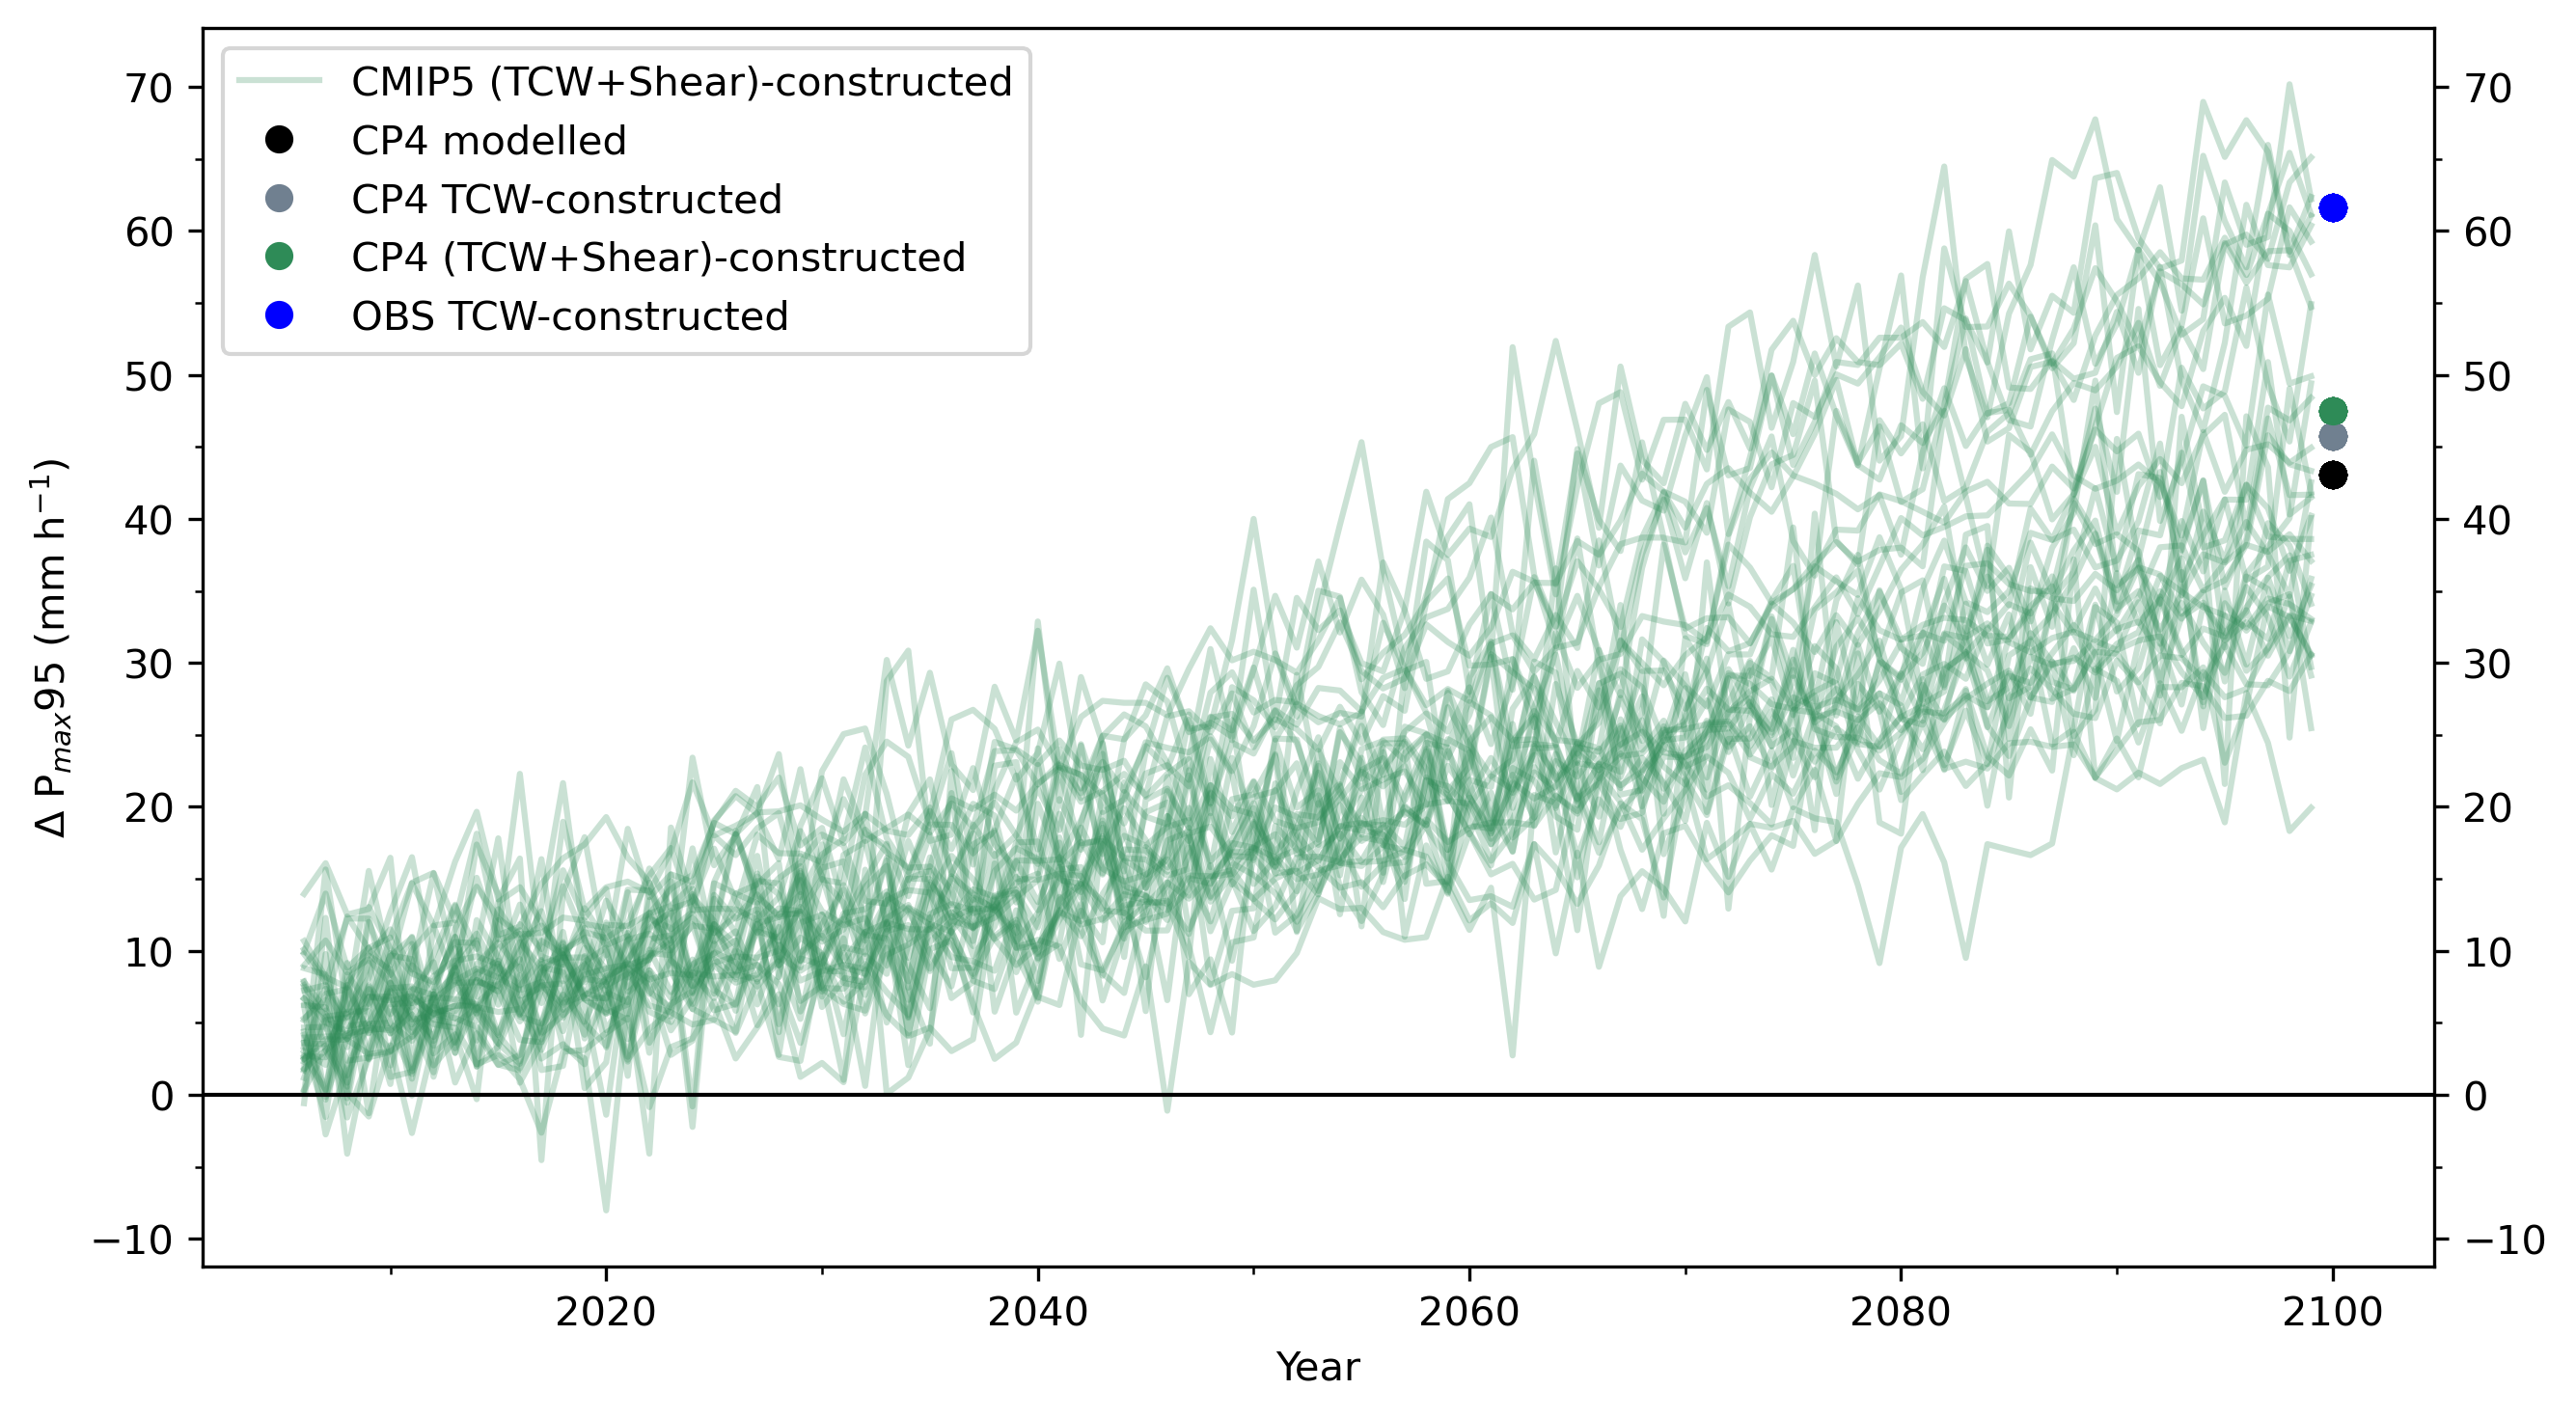

In [46]:
f = plt.figure(figsize=(9,5), dpi=300)


ax = f.add_subplot(1,1,1)  #cp4f_mcs_grid-

slevels=np.arange(-18,19,3)
tag='10'
yy ='2020-2100'
#ipdb.set_trace()
evenly_spaced_interval = np.linspace(0, 1, len(model_names))

colors = [cm.inferno(x) for x in evenly_spaced_interval]
for ids, mn in enumerate(model_names.values):
    tcw_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'/prw_*_'+mn+'_*.nc')[0]).squeeze()
    sh_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'/u*_'+mn+'_*.nc')[0]).squeeze()
    
    tcw_map = tcw_map.where(tcw_map['time.year']<=2099, drop=True)
    sh_map = sh_map.where(sh_map['time.year']<=2099, drop=True)
    
    #ds_merge = xr.merge([tcw_map, sh_map])

    ##relative CMIP change
    ds_shear = sh_map['unknown']*shearfac
    cmip_rel = (tcw_map['prw']/tcw_map['prw_hist'])

    years = np.unique(tcw_map['time.year'].values)

   # ipdb.set_trace()
   
    #new_ar_list05 =   cmip_rel *cp4_pos_array05 * cp4_prcp_array05#cp4hist_mcs95['prcp']
    new_ar_list95 =   cmip_rel *cp4_pos_array95 * cp4hist_mcs95['prcp']#cp4hist_mcs95['prcp']
   # sums05 = new_ar_list05 + ds_shear
    sums95 = new_ar_list95 + ds_shear
        
#     cp4construct =  cp4hist_mcs95['prcp'] * np.median(tcwvfac_all) * cp4_tcw_rel['tcwv'].values
#     cp4construct05 =  cp4hist_mcs95['prcp'] * cp4_pos_array05 * cp4_tcw_rel['tcwv'].values
    cp4construct95 =  cp4hist_mcs95['prcp'] * cp4_pos_array95 * cp4_tcw_rel['tcwv'].values
    
    obs_construct95 =  obs_mcs95['prcp'] * cp4_pos_array95 * cp4_tcw_rel['tcwv'].values
    
#     cp4total = cp4construct + cp4_shear_abs['u_pl']
#     cp4total05 = cp4construct05 + cp4_shear_abs['u_pl']
    cp4total95 = cp4construct95 + cp4_shear_abs['u_pl']*shearfac
    
   # print(cp4_shear_abs['u_pl'].values, cp4total95)
    
   # ax.plot(tcw_map['time.year'].values,sums05, color='k', alpha=0.25, label='CMIP5 [TCW$_{5}$+Shear]-constructed')
    ax.plot(tcw_map['time.year'].values,sums95, color='seagreen', alpha=0.25, label=r'CMIP5 (TCW+Shear)-constructed')
    #ax.plot(tcw_map['time.year'].values,new_ar_list, color='slategrey', alpha=0.9, label='CMIP5')
    #ax.plot(2006, cp4hist_mcs['prcp'], marker='o', color='k')
    ax.plot(2100, cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp'], marker='o', linestyle='', color='k', label=r'CP4 modelled')
    ax.plot(2100, cp4construct95, marker='o', linestyle='', color='slategrey', label=r'CP4 TCW-constructed')
    ax.plot(2100, cp4total95, marker='o', linestyle='', color='seagreen', label=r'CP4 (TCW+Shear)-constructed')
    ax.plot(2100, obs_construct95, marker='o', linestyle='', color='b', label=r'OBS TCW-constructed')
    #ax.errorbar(2101, cp4construct, yerr=np.array([[cp4construct-cp4construct05,cp4construct95-cp4construct]]).T, marker='o', color='slategrey', linestyle='', label=r'CP4 TCW-constructed')
    #ax.errorbar(2102, cp4total, yerr=np.array([[cp4total-cp4total05,cp4total95-cp4total]]).T, marker='o', color='seagreen', linestyle='', label=r'CP4 [TCW+Shear]-constructed')
    
    if ids==0:
        plt.legend()
    
# ax.text(2003,34,'CP4-historical TCW_95 (mm): '+str(np.round(cp4hist_mcs95['tcwv'],2)), fontsize=9)
# ax.text(2003,32,'CP4-historical P$_{max}$95 (mm h$^{-1}$): '+str(np.round(cp4hist_mcs95['prcp'],2)), fontsize=9)
# ax.text(2003,30,'CV: '+str(np.round(cp4_pos_array95,2)), fontsize=9)
ax.set_ylabel('$\Delta$ P$_{max}$95 (mm h$^{-1}$)')
ax.set_xlabel('Year')
ax.tick_params(axis='y', which='both', labelright='off', labelleft='on', right='on')
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.axhline(0, linestyle='solid', lw=1, color='k')



    
    #     new_ar_list.name = 'prw'
    #     ar_list.append(new_ar_list)

    # ds_scaled = xr.concat(ar_list, dim='model_name')
    # ds_merge['sum'] =  ds_shear +ds_scaled  #
    # ds_merge['contribution'] = ds_shear/ ds_merge['sum']*100

    # 
    # for mids in ds_merge['prw'].model_name:
    #     ax.plot(years, ds_merge['sum'].sel(model_name=mids))

plt.tight_layout()

# f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_Ouagadougou_timeseries_CP4_8mm.jpg')

In [1069]:
np.percentile(tcwvfac_all,[5,95])

array([1.10848882, 1.45944982])

In [1070]:


notfinite = np.isnan(cp4_pos_array)
f = plt.figure(figsize=(9,5), dpi=300)


ax = f.add_subplot(1,1,1)  #cp4f_mcs_grid-

slevels=np.arange(-18,19,3)
tag='10'
yy ='2020-2100'
#ipdb.set_trace()
evenly_spaced_interval = np.linspace(0, 1, len(model_names))

colors = [cm.inferno(x) for x in evenly_spaced_interval]
for ids, mn in enumerate(model_names.values):
    tcw_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'/prw_*_'+mn+'_*.nc')[0]).squeeze()
    sh_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'/u*_'+mn+'_*.nc')[0]).squeeze()
    
    tcw_map = tcw_map.where(tcw_map['time.year']<=2099, drop=True)
    sh_map = sh_map.where(sh_map['time.year']<=2099, drop=True)
    
    #ds_merge = xr.merge([tcw_map, sh_map])

    ##relative CMIP change
    ds_shear = sh_map['unknown']*shearfac
    cmip_rel = (tcw_map['prw']+tcw_map['prw_hist'])

    years = np.unique(tcw_map['time.year'].values)

   # ipdb.set_trace()
    new_ar_list =   cmip_rel #*cp4_pos_array * cp4hist_mcs['prcp']
    sums = new_ar_list #+ ds_shear
    if len(sums)>95:
        ipdb.set_trace()
        
    cp4construct =   cp4_tcw_hist['tcwv'] #cp4hist_mcs['prcp'] * cp4_pos_array *
    cp4total = cp4_tcw_fut['tcwv']#cp4construct + cp4_shear_abs['u_pl']
        
    ax.plot(tcw_map['time.year'].values,sums, color='seagreen', alpha=0.2, label='CMIP5-constructed from TCW+Shear')
    #ax.plot(tcw_map['time.year'].values,new_ar_list, color='slategrey', alpha=0.9, label='CMIP5')
    #ax.plot(2006, cp4hist_mcs['prcp'], marker='o', color='k')
    ax.plot(2100, cp4fut_mcs95['prcp'], marker='o', linestyle='', color='k', label='CP4-modelled MCS')
    ax.plot(2100, cp4total, marker='o', color='seagreen', linestyle='', label='CP4-TCW')
    ax.plot(2006, cp4construct, marker='o', color='seagreen', linestyle='', label='CP4-TCW')
    ax.plot(2006, cp4hist_mcs95['prcp'], marker='o', color='k', linestyle='', label='CP4-modelled MCS')
    
    if ids==0:
        plt.legend()
    
ax.text(2006,20,'CP4-historical P$_{max}$95 (mm h$^{-1}$): '+str(np.round(cp4hist_mcs95['prcp'],2)), fontsize=9)
#ax.text(2006,18,'CP4 $\Delta$TCW (%): '+str(np.round(cp4_tcw_rel['tcwv'].values*100,2)), fontsize=8)
ax.text(2006,18,'CV: '+str(np.round(cp4_pos_array,2)), fontsize=9)
ax.set_ylabel('$\Delta$ P$_{max}$95 (mm h$^{-1}$)')
ax.set_xlabel('Year')
ax.tick_params(axis='y', which='both', labelright='off', labelleft='on', right='on')
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
#ax.axhline(0, linestyle='solid', lw=1, color='k')



    
    #     new_ar_list.name = 'prw'
    #     ar_list.append(new_ar_list)

    # ds_scaled = xr.concat(ar_list, dim='model_name')
    # ds_merge['sum'] =  ds_shear +ds_scaled  #
    # ds_merge['contribution'] = ds_shear/ ds_merge['sum']*100

    # 
    # for mids in ds_merge['prw'].model_name:
    #     ax.plot(years, ds_merge['sum'].sel(model_name=mids))

plt.tight_layout()

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_Ouagadougou_timeseries_CP4_8mm.jpg')

NameError: name 'cp4_pos_array' is not defined

In [ ]:
cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp']

In [ ]:
cp4fut_mcs_mean['tcwv']-cp4hist_mcs_mean['tcwv']

In [ ]:
cp4hist_mcs_mean['tcwv']

In [ ]:
cp4_tcw_hist['tcwv']

In [ ]:


notfinite = np.isnan(cp4_pos_array)
f = plt.figure(figsize=(9,5), dpi=300)


ax = f.add_subplot(1,1,1)  #cp4f_mcs_grid-

slevels=np.arange(-18,19,3)
tag='10'
yy ='2020-2100'
#ipdb.set_trace()
evenly_spaced_interval = np.linspace(0, 1, len(model_names))

colors = [cm.inferno(x) for x in evenly_spaced_interval]
for ids, mn in enumerate(model_names.values):
    tcw_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'/prw_*_'+mn+'_*.nc')[0]).squeeze()
    sh_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'/u*_'+mn+'_*.nc')[0]).squeeze()
    
    tcw_map = tcw_map.where(tcw_map['time.year']<=2099, drop=True)
    sh_map = sh_map.where(sh_map['time.year']<=2099, drop=True)
    
    #ds_merge = xr.merge([tcw_map, sh_map])

    ##relative CMIP change
    ds_shear = sh_map['unknown']*shearfac
    cmip_rel = (tcw_map['prw'])

    years = np.unique(tcw_map['time.year'].values)

   # ipdb.set_trace()
    new_ar_list =   cmip_rel #*cp4_pos_array * cp4hist_mcs['prcp']
    sums = new_ar_list #+ ds_shear
    if len(sums)>95:
        ipdb.set_trace()
        
    cp4construct =   cp4_tcw_hist['tcwv'] #cp4hist_mcs['prcp'] * cp4_pos_array *
    cp4total = cp4_tcw_fut['tcwv']-cp4_tcw_hist['tcwv']#cp4construct + cp4_shear_abs['u_pl']
        
    ax.plot(tcw_map['time.year'].values,(sums)*1.3, color='seagreen', alpha=0.2, label='CMIP5-constructed from TCW+Shear')
    #ax.plot(tcw_map['time.year'].values,new_ar_list, color='slategrey', alpha=0.9, label='CMIP5')
    #ax.plot(2006, cp4hist_mcs['prcp'], marker='o', color='k')
    ax.plot(2100, cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp'], marker='o', linestyle='', color='k', label='CP4-modelled MCS')
    ax.plot(2100, (cp4fut_mcs_mean['tcwv']-cp4hist_mcs_mean['tcwv'])*1.3, marker='o', color='seagreen', linestyle='', label='CP4-TCW MCS')
    ax.plot(2100, cp4total*1.3, marker='o', color='b', linestyle='', label='CP4-TCW domain')
# 
    
    if ids==0:
        plt.legend()
    
ax.text(2006,20,'CP4-historical P$_{max}$95 (mm h$^{-1}$): '+str(np.round(cp4hist_mcs95['prcp'],2)), fontsize=9)
#ax.text(2006,18,'CP4 $\Delta$TCW (%): '+str(np.round(cp4_tcw_rel['tcwv'].values*100,2)), fontsize=8)
ax.text(2006,18,'CV: '+str(np.round(cp4_pos_array,2)), fontsize=9)
ax.set_ylabel('$\Delta$ P$_{max}$95 (mm h$^{-1}$)')
ax.set_xlabel('Year')
ax.tick_params(axis='y', which='both', labelright='off', labelleft='on', right='on')
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
#ax.axhline(0, linestyle='solid', lw=1, color='k')



    
    #     new_ar_list.name = 'prw'
    #     ar_list.append(new_ar_list)

    # ds_scaled = xr.concat(ar_list, dim='model_name')
    # ds_merge['sum'] =  ds_shear +ds_scaled  #
    # ds_merge['contribution'] = ds_shear/ ds_merge['sum']*100

    # 
    # for mids in ds_merge['prw'].model_name:
    #     ax.plot(years, ds_merge['sum'].sel(model_name=mids))

plt.tight_layout()

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_Ouagadougou_timeseries_CP4_8mm.jpg')